In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from Functions.databuild import dataBuilder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import plotly.graph_objects as go

from tqdm import tqdm


color_list_=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:olive','tab:cyan']


In [2]:
data = pd.read_parquet('./Data/FullData.parquet')

In [3]:
data.RunNumber.unique()

array(['293532', '307328', '307326', '307327', '293533', '308612',
       '306788', '306327', '309395', '308019', '308213', '308021',
       '307299', '306328', '309394', '306787', '297288', '306789',
       '306326', '308212', '303248', '310464', '310463', '303246',
       '308609', '309380', '309980', '303247', '310462', '310465',
       '302935', '309381', '298593', '307302', '298594', '298595',
       '307303', '293528', '307324', '293530', '308022', '308210',
       '308611', '308415', '308412', '308211', '308023', '308413',
       '308414', '308610', '306325', '306790', '309979', '309379',
       '309977', '303245', '309382', '309978', '307559', '307557',
       '307301', '307556', '298596', '307558'], dtype=object)

In [4]:
# numbers = ['293532', '307328', '307326', '307327', '293533']

numbers = ['293532', '307328', '307326']
data = data.loc[data.RunNumber.isin(numbers)]

In [5]:
print(data.shape)
data.head()

(1609728, 15)


,ChannelID,ChipID,Sector,ChannelNumber,Signal,CMSubstracted,ChipMean,ChipSigma,Staves,Rows,PedestalValue,Sigma,STD,SensorType,RunNumber
0,4194304,Chip0,UTaX_1CB_S4,Ch0,0.029467,0.918810,-0.11862,1.04342,1C,S4B,-7,-7.12525,1.55569,A,293532
1,4194305,Chip0,UTaX_1CB_S4,Ch1,0.203336,0.715657,-0.11862,1.04342,1C,S4B,-7,-6.75779,1.21160,A,293532
2,4194306,Chip0,UTaX_1CB_S4,Ch2,0.102181,0.731728,-0.11862,1.04342,1C,S4B,-6,-5.91200,1.13765,A,293532
3,4194307,Chip0,UTaX_1CB_S4,Ch3,-0.386058,0.786628,-0.11862,1.04342,1C,S4B,-5,-5.42700,1.20610,A,293532
4,4194308,Chip0,UTaX_1CB_S4,Ch4,-0.196124,0.754681,-0.11862,1.04342,1C,S4B,-5,-5.28600,1.21664,A,293532


In [6]:
#Taking only UTaX

utax = data[data.Sector.str.startswith('UTaX')]

#Run Number is in string format
utax.RunNumber = pd.to_numeric(utax.RunNumber)

In [7]:
#Reducing the granularity to Sector Level
columns_to_include = ['Sector'] + utax.select_dtypes(exclude='object').columns.tolist()

# Aggregating the codes to Sector and Run Number
# This will provide all the required data for each sector of UTaX Plan
sector_level_data = utax[columns_to_include].groupby(['Sector','RunNumber']).mean().reset_index()

sector_level_data

,Sector,RunNumber,ChannelID,Signal,CMSubstracted,ChipMean,ChipSigma,PedestalValue,Sigma,STD
0,UTaX_1AB_M1E,293532,5254911.5,1.176758e-08,0.547003,-0.023957,0.700991,1.507812,1.522711,0.612546
1,UTaX_1AB_M1E,307326,5254911.5,2.241135e-05,0.651391,-0.148003,0.787287,-0.248047,-0.396975,0.712275
2,UTaX_1AB_M1E,307328,5254911.5,-1.012612e-04,0.605971,0.111766,0.749038,0.285156,0.400737,0.663729
3,UTaX_1AB_M1W,293532,5254399.5,-1.200488e-07,0.540727,0.163820,0.665020,2.718750,2.792046,0.604437
4,UTaX_1AB_M1W,307326,5254399.5,-4.464070e-05,0.618984,0.184502,0.715371,0.103516,0.293693,0.663907
...,...,...,...,...,...,...,...,...,...,...
739,UTaX_8CT_S2,307326,4323583.5,1.253333e-04,0.882702,-0.178846,0.957037,-0.062500,-0.248453,0.944743
740,UTaX_8CT_S2,307328,4323583.5,-1.277919e-03,0.810853,0.072671,0.933195,0.121094,0.187783,0.873636
741,UTaX_8CT_S3,293532,4324607.5,-1.149326e-04,0.858979,-0.332644,1.013548,1.689453,1.593912,1.055257
742,UTaX_8CT_S3,307326,4324607.5,-3.239334e-04,0.822134,-0.006360,0.896799,0.666016,0.658357,0.875953


In [8]:
sector_level_data

,Sector,RunNumber,ChannelID,Signal,CMSubstracted,ChipMean,ChipSigma,PedestalValue,Sigma,STD
0,UTaX_1AB_M1E,293532,5254911.5,1.176758e-08,0.547003,-0.023957,0.700991,1.507812,1.522711,0.612546
1,UTaX_1AB_M1E,307326,5254911.5,2.241135e-05,0.651391,-0.148003,0.787287,-0.248047,-0.396975,0.712275
2,UTaX_1AB_M1E,307328,5254911.5,-1.012612e-04,0.605971,0.111766,0.749038,0.285156,0.400737,0.663729
3,UTaX_1AB_M1W,293532,5254399.5,-1.200488e-07,0.540727,0.163820,0.665020,2.718750,2.792046,0.604437
4,UTaX_1AB_M1W,307326,5254399.5,-4.464070e-05,0.618984,0.184502,0.715371,0.103516,0.293693,0.663907
...,...,...,...,...,...,...,...,...,...,...
739,UTaX_8CT_S2,307326,4323583.5,1.253333e-04,0.882702,-0.178846,0.957037,-0.062500,-0.248453,0.944743
740,UTaX_8CT_S2,307328,4323583.5,-1.277919e-03,0.810853,0.072671,0.933195,0.121094,0.187783,0.873636
741,UTaX_8CT_S3,293532,4324607.5,-1.149326e-04,0.858979,-0.332644,1.013548,1.689453,1.593912,1.055257
742,UTaX_8CT_S3,307326,4324607.5,-3.239334e-04,0.822134,-0.006360,0.896799,0.666016,0.658357,0.875953


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))


# Fit and transform the data
numericals_utax_scaled = pd.DataFrame(scaler.fit_transform(sector_level_data.drop('Sector',axis=1)))
numericals_utax_scaled.columns = sector_level_data.drop('Sector',axis=1).columns

In [10]:
numericals_utax_scaled

,RunNumber,ChannelID,Signal,CMSubstracted,ChipMean,ChipSigma,PedestalValue,Sigma,STD
0,0.000000,0.899652,0.345993,0.063062,0.469402,0.075157,0.792190,0.792423,0.306702
1,0.999855,0.899652,0.347010,0.242232,0.373396,0.148375,0.712044,0.704853,0.356636
2,1.000000,0.899652,0.341396,0.164272,0.574445,0.115922,0.736382,0.741242,0.332329
3,0.000000,0.899218,0.345987,0.052289,0.614732,0.044637,0.847464,0.850327,0.302642
4,0.999855,0.899218,0.343966,0.186608,0.630738,0.087357,0.728091,0.736359,0.332419
...,...,...,...,...,...,...,...,...,...
739,0.999855,0.109470,0.351682,0.639249,0.349525,0.292400,0.720514,0.711628,0.473033
740,1.000000,0.109470,0.287978,0.515929,0.544187,0.272172,0.728894,0.731528,0.437430
741,0.000000,0.110339,0.340775,0.598532,0.230493,0.340348,0.800481,0.795671,0.528367
742,0.999855,0.110339,0.331287,0.535291,0.483020,0.241292,0.753767,0.752994,0.438590


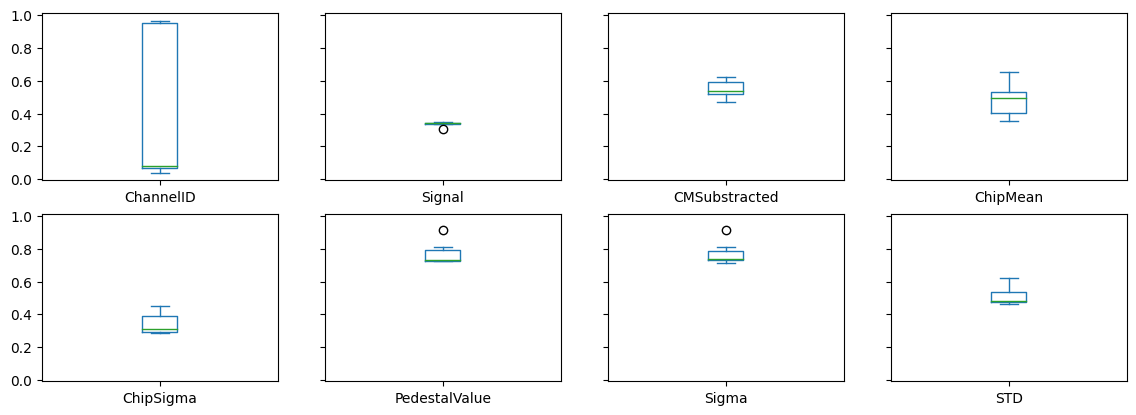

In [11]:
numericals_utax_scaled.drop(['RunNumber'],axis=1).sample(frac=0.01).plot(kind='box',layout=(4,4),
                                              subplots=True,figsize=(14,10),sharey=True)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
numericals_utax_scaled

,RunNumber,ChannelID,Signal,CMSubstracted,ChipMean,ChipSigma,PedestalValue,Sigma,STD
0,0.000000,0.899652,0.345993,0.063062,0.469402,0.075157,0.792190,0.792423,0.306702
1,0.999855,0.899652,0.347010,0.242232,0.373396,0.148375,0.712044,0.704853,0.356636
2,1.000000,0.899652,0.341396,0.164272,0.574445,0.115922,0.736382,0.741242,0.332329
3,0.000000,0.899218,0.345987,0.052289,0.614732,0.044637,0.847464,0.850327,0.302642
4,0.999855,0.899218,0.343966,0.186608,0.630738,0.087357,0.728091,0.736359,0.332419
...,...,...,...,...,...,...,...,...,...
739,0.999855,0.109470,0.351682,0.639249,0.349525,0.292400,0.720514,0.711628,0.473033
740,1.000000,0.109470,0.287978,0.515929,0.544187,0.272172,0.728894,0.731528,0.437430
741,0.000000,0.110339,0.340775,0.598532,0.230493,0.340348,0.800481,0.795671,0.528367
742,0.999855,0.110339,0.331287,0.535291,0.483020,0.241292,0.753767,0.752994,0.438590


In [14]:
xTrain, xTest = train_test_split(numericals_utax_scaled['PedestalValue'],shuffle=False,test_size=0.05)

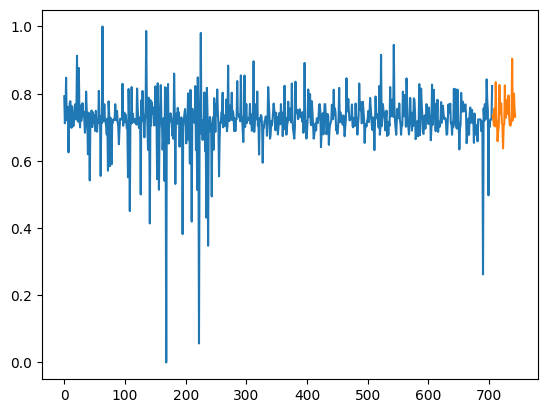

In [15]:
plt.plot(xTrain)
plt.plot(xTest)
plt.show()

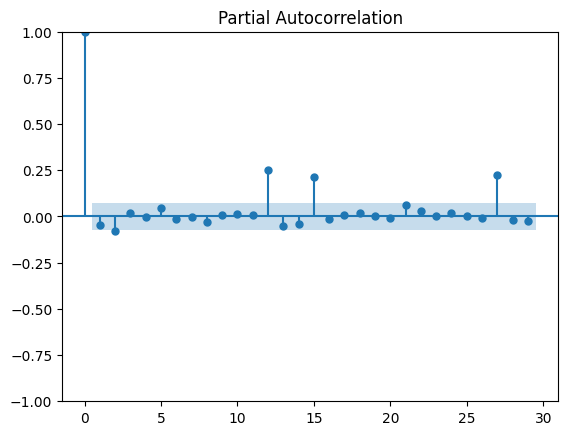

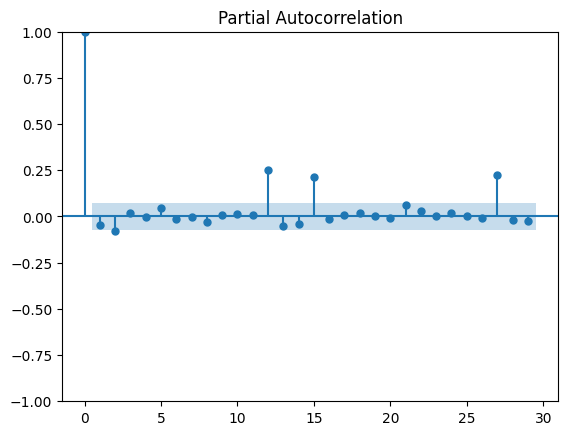

In [16]:
#finding I
plot_pacf(xTrain)

In [17]:
#Looping for the parameters.

d=0
loss=[]
for p in tqdm(range(15)):
    for q in range(10):

        model = ARIMA(xTrain, order=(p,d,q))
        model_fit = model.fit()

        # Summary of the model
        # print(model_fit.summary())
        forecast = model_fit.forecast(steps=xTest.shape[0]) 
        # print(forecast)

        loss_=np.sqrt(mean_squared_error(xTest,forecast))
        loss.append((p, d, q, loss_))

  0%|          | 0/15 [00:00<?, ?it/s]/Users/sabinhashmi/miniconda3/envs/workbox/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 1/15 [00:06<01:24,  6.06s/it]/Users/sabinhashmi/miniconda3/envs/workbox/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 13%|█▎        | 2/15 [00:13<01:31,  7.07s/it]/Users/sabinhashmi/miniconda3/envs/workbox/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sabinhashmi/miniconda3/envs/workbox/lib/python3.8/site-packages/statsmodels/base/model.py:607: Convergen

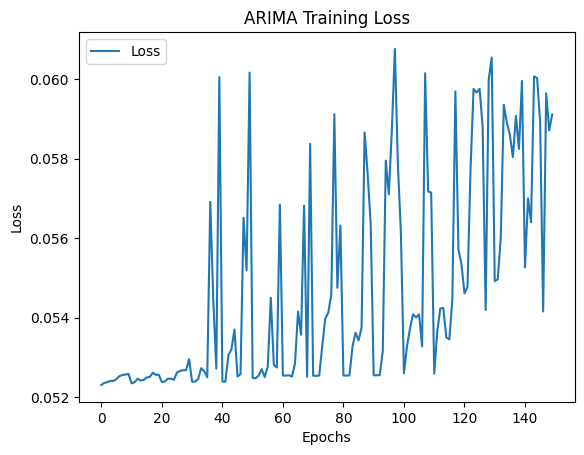

In [18]:
lossData=pd.DataFrame(loss,columns=['p','d','q','loss'])
lossData

plt.title('ARIMA Training Loss')

plt.plot(lossData['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Create an interactive plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=lossData['loss'],
    mode='lines',
    name='Loss'
))

fig.update_layout(
    title='Model Loss Over Time',
    xaxis_title='Epoch',
    yaxis_title='Loss'
)

# Show the plot
fig.show()


In [20]:
lossData.sort_values(by='loss').head(20)

,p,d,q,loss
0,0,0,0,0.052304
10,1,0,0,0.052344
1,0,0,1,0.052354
11,1,0,1,0.052372
2,0,0,2,0.052375
20,2,0,0,0.052376
30,3,0,0,0.052383
31,3,0,1,0.052386
41,4,0,1,0.052387
40,4,0,0,0.052390


/Users/sabinhashmi/miniconda3/envs/workbox/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



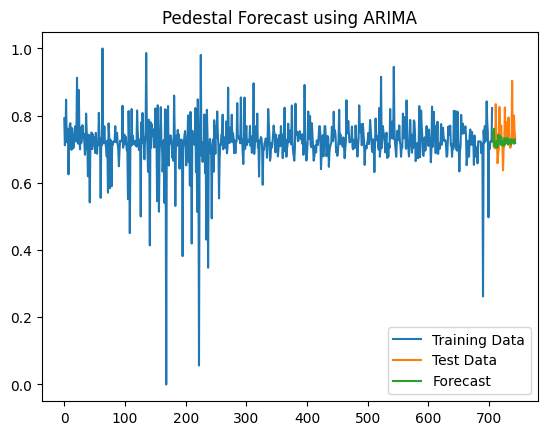

In [21]:
model = ARIMA(xTrain, order=(10,0,5))  # Example order, typically chosen through model selection criteria
model_fit = model.fit()

# Summary of the model
# print(model_fit.summary())
forecast = model_fit.forecast(steps=xTest.shape[0])  # Forecasting next 12 periods (1 year)
# print(forecast)

plt.plot(xTrain,label='Training Data')
plt.plot(xTest,label = 'Test Data')
plt.plot(forecast, label = 'Forecast')
plt.legend()
plt.title('Pedestal Forecast using ARIMA')

plt.show()
